# Weibel instability

In this project, we are going to look at the dispersion relation for the "true" Weibel instability, produced for an anisotropic temperature distribution in the electrons.

In this project, you will study the accuracy of the analytical dispersion relation for electromagnetic waves in the Weibel instability.

For both waves, $\vec k \parallel \vec B_0$, $\vec E_1 \perp \vec B_0$, and $\vec k \perp \vec E_1$ (transverse waves).  

From Morse and Nielson (1971), the dispersion relation is:

$$ \left(\frac{k_2 c}{\omega_p}\right)^2 - \left(\frac{\omega}{\omega_p}\right)^2 = A+(A+1)\left(\frac{\omega}{k_2 u_2}\right)Z\left(\frac{\omega}{k_2 u_2}\right) ,$$

where $u_1$ and $u_1$ are thermal velocities in $x_1$ and $x_2$, respectively, $A=\left(\frac{u_1}{u_2}\right)^2-1$, and $Z$ is the plasma dispersion function defined as

$$ Z(x) = 2i e^{-x^2} \int_{-\infty}^{ix} e^{-t^2} dt .$$

An equivalent version of the dispersion relation is

$$ \left(\frac{\omega}{\omega_p}\right)^2 - \left(\frac{k_2 c}{\omega_p}\right)^2 = 1+\frac{1}{2}\left(\frac{u_1}{u_2}\right)^2 Z'\left(\frac{\omega}{k_2 u_2}\right) .$$

The unstable roots of $\omega$ in this equation are pure imaginary. We can define the dimensionless quantities $k \equiv \frac{k_2 c}{\omega_p}$, $w \equiv \frac{\omega}{\omega_p}$, and $\tilde{u}_2 \equiv \frac{u_2}{c}$, along with assuming purely imaginary growing waves, i.e., $w=i\gamma$, the dispersion relation reduces to

$$ k^2+\gamma^2=A+(A+1)\left(\frac{i\gamma}{k \tilde{u}_2}\right)Z\left(\frac{i\gamma}{k \tilde{u}_2}\right) .$$

This is the dispersion relation we will be solving to obtain the unstable modes.

In this project you will study the unstable $B_3$ modes with an electron temperature anisotropy. You will simulate a plasma in which each plasma electron is initialized with positions (only in $x$ and $y$, or what we call $x_1$ and $x_2$). The ions are initialized at the same positions but they have an infinite mass.  Each electron is also initialized with velocities ($v_1$, $v_2$, $v_3$) or momenta ($mv_1$, $mv_2$, $mv_3$) from a Maxwellian in each direction. The temperature will be hotter in the $x_1$ direction, e.g., $\vec u=(0.25c,0.05c,0.05c)$. The particles then begin to move in the self-consistent fields that their current and charge density produce.

* The length of the plasmas is 15 $c/\omega_p$ by 30 $c/\omega_p$
* The simulation will run for a time 50 $1/\omega_p$.
* The simulation uses 295,000 particles.

You will be looking at plots of the magnetic field in the $x_1$ and $x_2$ directions ($B_3$), along with Fourier transforms of the same.

## Weibel dispersion relation

Here you can look at the dispersion relation of the Weibel instability and the frequencies described above.  You can run the cell below and then change the value of $u_x$ and $u_y$:

In [1]:
from scipy.special import erfi
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
%matplotlib inline

def Z(x):
    return -1*mp.exp(-mp.power(x,2))*mp.sqrt(mp.pi) * (-1j + mp.erfi(x))

karray=np.linspace(.01,6,30)
g=np.zeros_like(karray)

def h(ux,uy,show):
    A=np.square((ux/uy))-1
    func = []
    for i,k in enumerate(karray):
        def f(g):
            return mp.power(k,2)+mp.power(g,2)-A-(A+1)*(1j*g)/(k*uy)*Z((1j*g)/(k*uy))
        func.append(f)

    prev_root = 0.0001
    for i,k in enumerate(karray):
        g[i] = mp.findroot(func[i],prev_root,solver='newton').real
        prev_root = g[i]


    plt.figure()
    plt.plot(karray,g)
    plt.xlim([0,6])
    plt.ylim([0,.035])
    plt.xlabel(r'$k$')
    plt.ylabel(r'$\gamma$')
    if show:
        plt.show()

interact(h,ux=(.04,.06,.01),uy=fixed(.01),show=fixed(True))

interactive(children=(FloatSlider(value=0.05, description='ux', max=0.06, min=0.04, step=0.01), Output()), _do…

<function __main__.h(ux, uy, show)>

# Simulations with a Particle-in-Cell Code

### The following lines must always be executed before running anything else.

Reminder: Hit Shift+Enter to run a cell, or select the cell and click on the "Run" button in the top menu bar

In [2]:
import osiris

## Run simulation

In [3]:
dirname = 'test-05'
osiris.runosiris_2d(rundir=dirname,inputfile='weibel.txt')

runosiris completed normally


## Analyze data

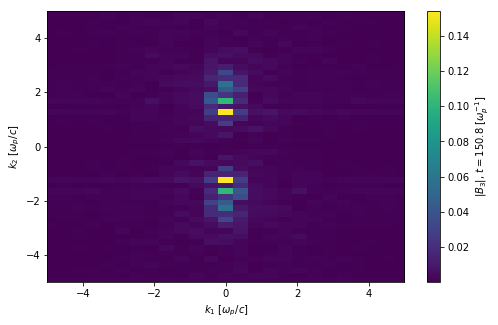

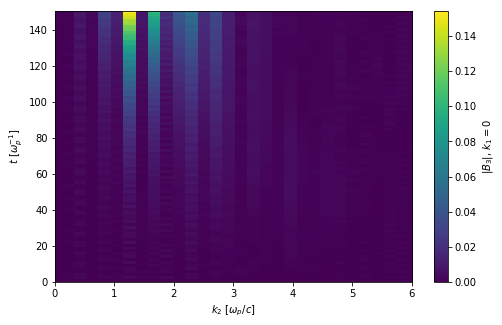

In [4]:
from h5_utilities import *

hdf5_data = read_hdf(os.getcwd()+'/test-05/b3.h5')

xlims = [hdf5_data.axes[0].axis_min,hdf5_data.axes[0].axis_max,
         hdf5_data.axes[1].axis_min,hdf5_data.axes[1].axis_max]
tlims = [hdf5_data.axes[2].axis_min,hdf5_data.axes[2].axis_max]
nx = np.flip(hdf5_data.data.shape,axis=0)
dx = [(hdf5_data.axes[0].axis_max-hdf5_data.axes[0].axis_min)/nx[0],
      (hdf5_data.axes[1].axis_max-hdf5_data.axes[1].axis_min)/nx[1]]
kx=2*np.pi*np.fft.fftshift(np.fft.fftfreq(nx[0],dx[0]))
ky=2*np.pi*np.fft.fftshift(np.fft.fftfreq(nx[1],dx[1]))
t=np.linspace(tlims[0],tlims[1],nx[-1])

# plot modes at the latest time
t_ind=-1
plt.figure(figsize=(8,5))
plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(hdf5_data.data[t_ind,:,:],norm='ortho'))),
          origin='lower',extent=[np.min(kx),np.max(kx),np.min(ky),np.max(ky)],aspect='auto')
plt.xlim((-5,5))
plt.ylim((-5,5))
c=plt.colorbar()
c.set_label('$|B_3|$, $t='+'{:.1f}'.format(t[t_ind])+'$ $[\omega_p^{-1}]$')
plt.xlabel('$k_1$ $[\omega_p/c]$')
plt.ylabel('$k_2$ $[\omega_p/c]$')
plt.show()

# perform fft and pick out kx = 0
data=np.abs(np.fft.fftshift(np.fft.fftn(hdf5_data.data,axes=(1,2),norm='ortho')[:,:,0],
                                             axes=1))

# plot time history of kx=0 modes
plt.figure(figsize=(8,5))
plt.imshow(data,origin='lower',extent=[np.min(ky),np.max(ky),tlims[0],tlims[1]],aspect='auto')
c=plt.colorbar()
c.set_label('$|B_3|$, $k_1=0$')
plt.xlabel('$k_2$ $[\omega_p/c]$')
plt.ylabel('$t$ $[\omega_p^{-1}]$')
plt.xlim((0,6))
plt.show()

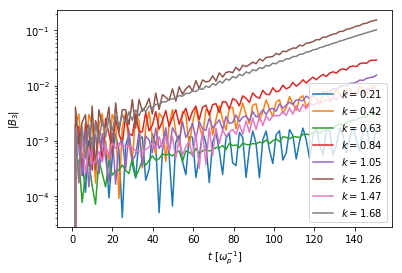

In [5]:
plt.figure()
for i in range(8):
    plt.semilogy(np.linspace(tlims[0],tlims[1],nx[-1]),data[:,int(data.shape[1]/2)+i+1],
                 label='$k='+'{:.2f}'.format(ky[int(data.shape[1]/2)+i+1])+'$')
plt.legend(loc='lower right')
plt.xlabel('$t$ $[\omega_p^{-1}]$')
plt.ylabel('$|B_3|$')
plt.show()

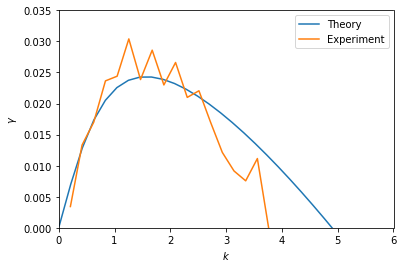

In [6]:
modes=20
lim=[30,150]
g_exp = np.zeros(modes)
k_exp = np.zeros(modes)
show=False

ux=.05;uy=.01
for i in range(modes):
    x=np.linspace(tlims[0],tlims[1],nx[-1])
    y=data[:,int(data.shape[1]/2)+i+1]
    f=np.argmax(x>lim[0])
    l=np.argmin(x<lim[1])
    m,b = np.polyfit(x[f:l], np.log(y[f:l]), 1, w=np.sqrt(y[f:l]))
    if show:
        print('m =',m,'  ky =',ky[int(data.shape[1]/2)+i+1])
    
    ktest=np.array([ky[int(data.shape[1]/2)+i+1]])
    g_loc=np.zeros_like(ktest)
    def g_plain(ux,uy):
        A=np.square((ux/uy))-1
        func = []
        for i,k in enumerate(ktest):
            def f(g):
                return mp.power(k,2)+mp.power(g,2)-A-(A+1)*(1j*g)/(k*uy)*Z((1j*g)/(k*uy))
            func.append(f)

        prev_root = 0.0001
        for i,k in enumerate(ktest):
            g_loc[i] = mp.findroot(func[i],prev_root,solver='newton').real
            prev_root = g_loc[i]

        return g

    m_calc = g_plain(ux,uy)[0]
    if show:
        print('m_calc =',m_calc)
    
    if show:
        plt.figure()
        plt.semilogy(x,y)
        plt.semilogy(x[f:l],np.exp(b+m*x[f:l]))
        plt.semilogy(x[f:l],np.exp(b+m_calc*x[f:l]))
        plt.show()
    
    g_exp[i] = m
    k_exp[i] = ky[int(data.shape[1]/2)+i+1]

h(ux,uy,show=False)
plt.plot(k_exp,g_exp)
plt.legend(('Theory','Experiment'))
plt.ylim((0,.035))
plt.show()

# Extra analysis routines

In [ ]:
osiris.fieldinteract_2d(rundir=dirname,dataset='b3')

In [ ]:
osiris.field_2d(rundir=dirname, dataset='e2', time=.5)

In [ ]:
osiris.phasespace_2d(rundir=dirname, dataset='p1x1', time=.5)